Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

Модифицировать решение первого задания путем добавления 
-регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

In [72]:
import matplotlib
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
X, y, W_default = make_regression(
    n_features=10,
    bias=3.5,
    noise=1.2,
    coef=True,
    random_state=42
)

In [74]:
# вектор весов данной модели
W_default

array([16.74825823, 54.12963353,  5.19712837, 63.64302495, 93.62122462,
       70.64757265, 87.09691237, 10.45678403,  3.15861448, 70.90605195])

In [75]:
# рассчет предсказания модели
y_pred_default = X @ W_default

In [76]:
# mse
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred) ** 2)
    return err

In [77]:
mse_default = calc_mse(y, y_pred_default)
mse_default

14.867688515340442

In [78]:
# оптимизация методом градиентного спуска
def my_grad_desc(X, y, alpha=1e-04, verbose=False, tol=0.0):
    n = X.shape[0]
    W = np.random.randn(X.shape[1], )  
    min_err = float('inf')  
    n_iter = 0  
    stop_chek = True  
    errors = []  
    while stop_chek:
        n_iter += 1
        y_pred = W @ X.T
        err = calc_mse(y, y_pred)
        errors.append(err)
        if min_err - err > tol:  
            min_err = err
        else:  
            print(
                f'Stop descent! iteration: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        W -= alpha * (1 / n * 2 * np.sum(X.T * (y_pred - y), axis=1))
        if verbose:
            if n_iter % 100 == 0:
                print(n_iter, W, err)
    return W, min_err, errors

In [79]:
W_1, mse_1, score_1 = my_grad_desc(X, y, alpha=0.001, tol=0.00001)

Stop descent! iteration: 6773, weights: [17.01879338 54.47004271  4.75428088 63.30968294 93.3978385  71.0415355
 86.98584811 10.23648107  3.51119789 70.81215459], mse: 14.301241547320648


In [80]:
# стохастический градиентный спуск
def my_sgd(X, y, alpha=1e-04, batch_size=1, n_epoch=1e+06, verbose=False, tol=0.0):
    n = X.shape[0]
    W = np.random.randn(X.shape[1], )  
    n_batch = n // batch_size  
    if n % batch_size != 0:
        n_batch += 1
    min_err = float('inf')  
    n_iter = 0  
    stop_chek = True  
    errors = []  
    while stop_chek:
        n_iter += 1
        for b in range(n_batch):
            start_ = batch_size * b
            end_ = batch_size * (b + 1)
            X_tmp = X.T[:, start_: end_]
            y_tmp = y[start_: end_]
            y_pred = W @ X_tmp
            err = calc_mse(y_tmp, y_pred)
            W -= alpha * (1 / n * 2 * (y_pred - y_tmp) @ X_tmp.T)
        errors.append(err)
        if verbose:
            if n_iter % 1000 == 0:
                print(n_iter, W, err)
        if n_iter==n_epoch:                      
            print(
                f'Stop descent! n_epoch: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        if np.abs(min_err - err) > tol:          
            min_err = err if err<=min_err else min_err
        else:                                    
            print(
                f'Stop descent! n_epoch: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        
    return W, min_err, errors

In [81]:
W_2, mse_2, score_2 = my_sgd(X, y, alpha=0.001, batch_size=1, n_epoch=8000, tol=0.00001)

Stop descent! n_epoch: 5544, weights: [17.0375372  54.51867936  4.68711962 63.30844612 93.33151055 71.12621252
 86.89551788 10.13594045  3.53912407 70.69628332], mse: 11.000837740157726


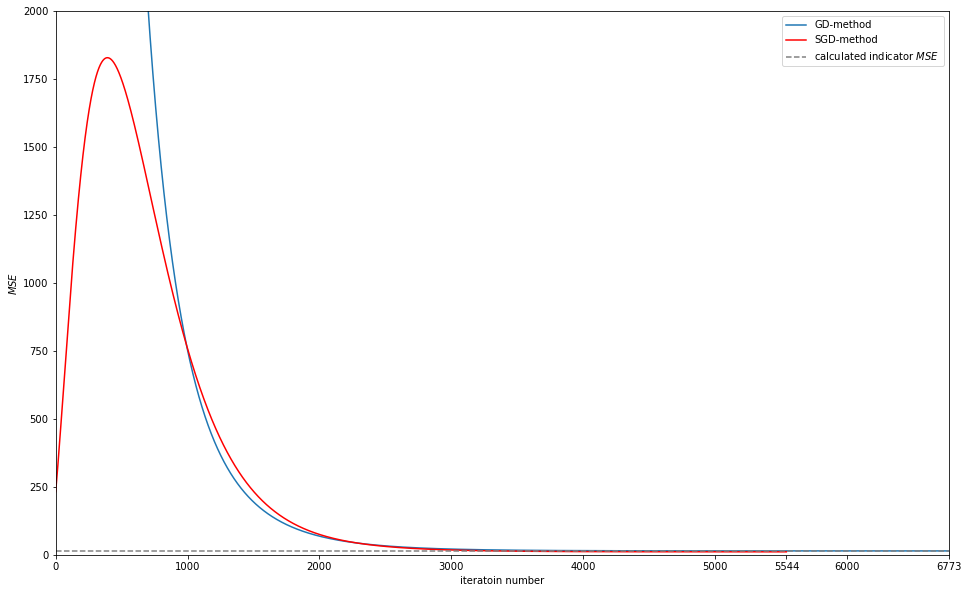

In [82]:
plt.figure(figsize=(16, 10))
plt.ylim((0,2000))
plt.xlim((0,len(score_1)-1000))
plt.plot([x for x in range(len(score_1))], score_1, label='GD-method')
plt.plot([x for x in range(len(score_2))], score_2, c='r', label='SGD-method')
plt.axhline(mse_default, c='gray', ls='--', label=r'calculated indicator $MSE$', mew=0.9)
plt.xlabel('iteratoin number')
plt.xticks(list(plt.xticks()[0])+[len(score_1), len(score_2)])
plt.ylabel(r'$MSE$')
plt.legend()
plt.show()

In [83]:
len(score_1)

6773

Из графика видно, что стохастический градиентный спуск до 800-ой итерации расходился, затем оба алгоритма сходились до уровня 2300-2400, при этом скорость схождения была выше у градиентного спуска, но затем скорости сравнялись и стохастический градиентный спуск сошелся быстрее, чем градиентный

In [84]:
# L2 (Евклидова) норма вектора
def euclid(vec):
    norm=0
    for i in vec:
        norm+=i**2
    return norm**0.5

In [85]:
def my_grad_desc_reg(X, y, alpha=1e-04, verbose=False, tol=0.0, lambda_=0.0):
    n = X.shape[0]
    W = np.random.randn(X.shape[1], )  
    min_err = float('inf')  
    n_iter = 0  
    stop_chek = True  
    errors = []  
    while stop_chek:
        n_iter += 1
        y_pred = W @ X.T
        err = calc_mse(y, y_pred)+lambda_*euclid(W) 
        errors.append(err)
        if min_err - err > tol:  
            min_err = err
        else:  
            print(
                f'Stop descent! iteration: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        W -= alpha * (1 / n * 2 * np.sum(X.T * (y_pred - y), axis=1))+lambda_*W # добавим коэфф. лямбда для расчёта весов
        if verbose:
            if n_iter % 1000 == 0:
                print(n_iter, W, err)
    return W, min_err, errors

In [86]:
W_3, mse_3, score_3 = my_grad_desc_reg(X, y, alpha=0.001, tol=0.00001, lambda_=0.0000001)

Stop descent! iteration: 6813, weights: [17.01849484 54.46690297  4.75444672 63.30677349 93.39287427 71.03861461
 86.98259787 10.2347441   3.51154981 70.80893887], mse: 14.301657967018896


In [87]:
def my_sgd_reg(X, y, alpha=1e-04, batch_size=1, n_epoch=1e+06, verbose=False, tol=0.0, lambda_=0.0):
    
    n = X.shape[0]
    W = np.random.randn(X.shape[1], )  
    n_batch = n // batch_size  
    if n % batch_size != 0:
        n_batch += 1
    min_err = float('inf')  
    n_iter = 0  
    stop_chek = True  
    errors = []  
    while stop_chek:
        n_iter += 1
        for b in range(n_batch):
            start_ = batch_size * b
            end_ = batch_size * (b + 1)
            X_tmp = X.T[:, start_: end_]
            y_tmp = y[start_: end_]
            y_pred = W @ X_tmp
            err = calc_mse(y_tmp, y_pred)+lambda_*euclid(W) 
            W -= alpha * (1 / n * 2 * (y_pred - y_tmp) @ X_tmp.T)+lambda_*W
        errors.append(err)
        if verbose:
            if n_iter % 1000 == 0:
                print(n_iter, W, err)
        if n_iter==n_epoch:                      
            print(
                f'Stop descent! n_epoch: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        if np.abs(min_err - err) > tol:          
            min_err = err if err<=min_err else min_err
        else:                                    
            print(
                f'Stop descent! n_epoch: {n_iter}, weights: {W}, mse: {min_err}')
            stop_chek = False
        
    return W, min_err, errors

In [88]:
W_4, mse_4, score_4 = my_sgd_reg(X, y, alpha=0.001, batch_size=1, n_epoch=8000, tol=0.00001, lambda_=0.0000001)

Stop descent! n_epoch: 5525, weights: [17.0348364  54.27110126  4.61219327 63.01578219 92.74837625 70.95207079
 86.44944141  9.82771605  3.61298888 70.21595396], mse: 14.567099343149701


In [89]:
#сравнение полученных результатов
df = pd.DataFrame(
    {
        'methods':['GD', 'SGD','GD + L2','SGD + L2'],
        r'$\lambda$-coeff':[None,None,0.001,0.001],
        'tol-value': 0.00001,
        'iterations': [len(it) for it in [score_1, score_2, score_3,score_4]],
        'err-value': [it[-1] for it in [score_1, score_2, score_3,score_4]]
    }
)
df

,methods,$\lambda$-coeff,tol-value,iterations,err-value
0,GD,NaN,0.00001,6773,14.301232
1,SGD,NaN,0.00001,5544,11.000828
2,GD + L2,0.001,0.00001,6813,14.301648
3,SGD + L2,0.001,0.00001,5525,14.567089


In [90]:
#сравнение весов
df2=pd.DataFrame({'GD':W_1, 'SGD':W_2,'GD + L2':W_3,'SGD + L2':W_4}, index=['weigt'+str(i) for i in range(10)])
df2

,GD,SGD,GD + L2,SGD + L2
weigt0,17.018787,17.037537,17.018489,17.034836
weigt1,54.470020,54.518679,54.466880,54.271101
weigt2,4.754311,4.687120,4.754476,4.612193
weigt3,63.309682,63.308446,63.306773,63.015782
weigt4,93.397867,93.331511,93.392902,92.748376
weigt5,71.041498,71.126213,71.038578,70.952071
weigt6,86.985889,86.895518,86.982637,86.449441
weigt7,10.236525,10.135940,10.234787,9.827716
weigt8,3.511186,3.539124,3.511538,3.612989
weigt9,70.812205,70.696283,70.808987,70.215954


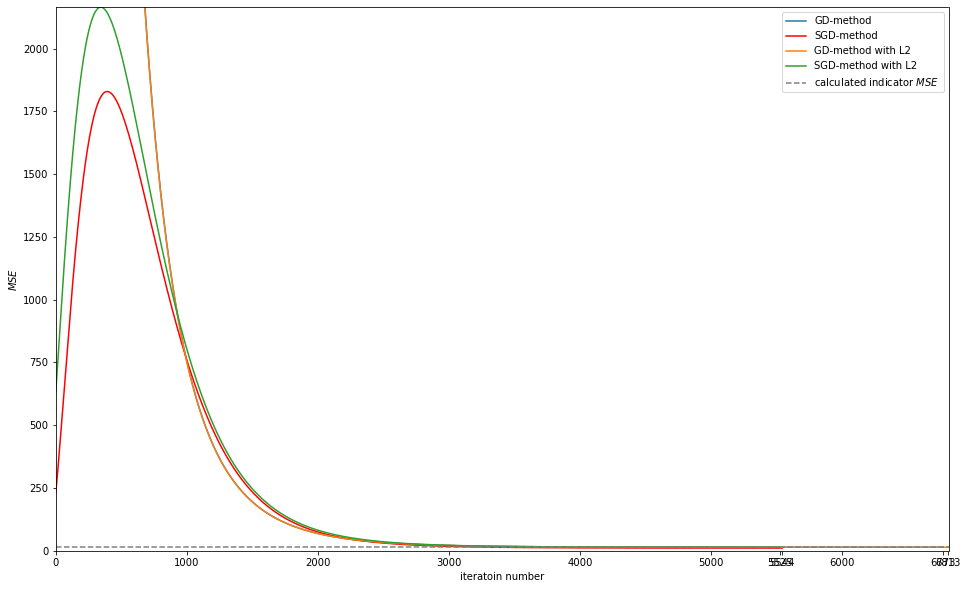

In [91]:
plt.figure(figsize=(16, 10))
plt.ylim((0,np.max([np.max(score_2),np.max(score_4)])))
plt.xlim((0,np.max([len(score_1), len(score_2), len(score_3), len(score_4)])-1000))
plt.plot([x for x in range(1, len(score_1) + 1)], score_1, label='GD-method')
plt.plot([x for x in range(1, len(score_2) + 1)], score_2, c='r', label='SGD-method')
plt.plot([x for x in range(1, len(score_3) + 1)], score_3, label='GD-method with L2')
plt.plot([x for x in range(1, len(score_4) + 1)], score_4, label='SGD-method with L2')
plt.axhline(mse_default, c='gray', ls='--', label=r'calculated indicator $MSE$', mew=0.9)
plt.xticks(list(plt.xticks()[0])+[len(score_1), len(score_2), len(score_3), len(score_4)])
plt.xlabel('iteratoin number')
plt.ylabel(r'$MSE$')
plt.legend()
plt.show()